In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 6.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)
CHANNELS = 3
BATCH_SIZE = 16    # Adjust based on GPU memory
EPOCHS = 100

In [ ]:


# Define directories
image_dir = '/content/drive/MyDrive/final_DHinput/data'
mask_dir = '/content/drive/MyDrive/OUTPUT_MASK'

# Define image and mask loading functions
def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Image not found at {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype("float32") / 255.0
    return img

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Mask not found at {path}")
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask.astype("float32") / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Set image dimensions (adjust these as needed)
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Get class names from subdirectories
class_names = sorted([d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))])
print("Detected classes:", class_names)

# Create class-to-index mapping
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Initialize lists to store images, masks, and labels
seg_images = []
seg_masks = []
cls_labels = []

# Traverse each class subdirectory
for cls in class_names:
    img_subdir = os.path.join(image_dir, cls)
    mask_subdir = os.path.join(mask_dir, cls)

    if not os.path.isdir(mask_subdir):
        print(f"Mask subdirectory {mask_subdir} not found!")
        continue

    img_files = [f for f in os.listdir(img_subdir) if f.lower().endswith('.jpg')]
    print(f"Found {len(img_files)} images in {img_subdir}")

    for img_file in img_files:
        base_name = os.path.splitext(img_file)[0]  # e.g., 'PLATELET_763038'
        mask_file = base_name + '.png'
        mask_path = os.path.join(mask_subdir, mask_file)

        if os.path.exists(mask_path):
            img_path = os.path.join(img_subdir, img_file)
            try:
                image = load_image(img_path)
                mask = load_mask(mask_path)
                seg_images.append(image)
                seg_masks.append(mask)
                cls_labels.append(class_to_idx[cls])
            except Exception as e:
                print(f"Error loading {img_path} or {mask_path}: {e}")
                continue
        else:
            print(f"Mask not found for {os.path.join(img_subdir, img_file)}")

# Convert to numpy arrays
seg_images = np.array(seg_images)
seg_masks = np.array(seg_masks)
cls_labels = np.array(cls_labels)

# Convert labels to one-hot encoding
NUM_CLASSES = len(class_names)
cls_labels_onehot = tf.keras.utils.to_categorical(cls_labels, NUM_CLASSES)

print(f"✅ Found {len(seg_images)} image-mask pairs.")
print("Images shape:", seg_images.shape)
print("Masks shape:", seg_masks.shape)
print("Classification labels shape:", cls_labels_onehot.shape)

Detected classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Found 1208 images in /content/drive/MyDrive/final_DHinput/data/basophil
Found 2507 images in /content/drive/MyDrive/final_DHinput/data/eosinophil
Found 1541 images in /content/drive/MyDrive/final_DHinput/data/erythroblast
Found 2885 images in /content/drive/MyDrive/final_DHinput/data/ig
Found 1204 images in /content/drive/MyDrive/final_DHinput/data/lymphocyte
Found 1410 images in /content/drive/MyDrive/final_DHinput/data/monocyte
Found 3319 images in /content/drive/MyDrive/final_DHinput/data/neutrophil
Found 2338 images in /content/drive/MyDrive/final_DHinput/data/platelet
✅ Found 16412 image-mask pairs.
Images shape: (16412, 224, 224, 3)
Masks shape: (16412, 224, 224, 1)
Classification labels shape: (16412, 8)


In [ ]:

# 5. Split Data into Training and Validation Sets
# ----------------------------------
X_train, X_val, y_cls_train, y_cls_val, y_mask_train, y_mask_val = train_test_split(
    seg_images, cls_labels_onehot, seg_masks, test_size=0.2, random_state=42
)
print("Training set:", X_train.shape, y_cls_train.shape, y_mask_train.shape)
print("Validation set:", X_val.shape, y_cls_val.shape, y_mask_val.shape)

Training set: (13129, 224, 224, 3) (13129, 8) (13129, 224, 224, 1)
Validation set: (3283, 224, 224, 3) (3283, 8) (3283, 224, 224, 1)


In [ ]:
IMG_HEIGHT = 224

In [ ]:
# 6. tf.data.Dataset + Data Augmentation
# --------------------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def augment_fn(image, mask):
    augmented_img = data_augmentation(image)
    random_value = tf.random.uniform(())
    def flip_mask():
        return tf.reverse(mask, axis=[1])
    def no_flip_mask():
        return mask
    final_mask = tf.cond(random_value < 0.5, flip_mask, no_flip_mask)
    return augmented_img, final_mask

def create_dataset(X, y_cls, y_mask, batch_size, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, {"classification": y_cls, "segmentation": y_mask}))
    dataset = dataset.shuffle(buffer_size=len(X), seed=42, reshuffle_each_iteration=True)
    if augment:
        def map_fn(x, y):
            img, msk = augment_fn(x, y["segmentation"])
            return (img, {"classification": y["classification"], "segmentation": msk})
        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, y_cls_train, y_mask_train, BATCH_SIZE, augment=True)
val_dataset   = create_dataset(X_val,   y_cls_val,   y_mask_val,   BATCH_SIZE, augment=False)

In [ ]:
# 7. Custom Metrics (Dice, IoU, etc.)
# -----------------------------------
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

def seg_precision(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred_binary), tf.float32)
    true_positives = K.sum(y_true_f * y_pred_f)
    predicted_positives = K.sum(y_pred_f)
    return (true_positives + smooth) / (predicted_positives + smooth)

def seg_recall(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_binary = tf.cast(y_pred > 0.5, tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred_binary), tf.float32)
    true_positives = K.sum(y_true_f * y_pred_f)
    possible_positives = K.sum(y_true_f)
    return (true_positives + smooth) / (possible_positives + smooth)

In [ ]:
# 8. Build a Multi-Task Model with ResNet50 Backbone & U-Net–style Decoder
# ------------------------------------------------------------------------
def build_multitask_resnet_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=NUM_CLASSES):
    """
    Builds a multi-task network:
      1) Classification branch using global pooling on top of a ResNet50 backbone
      2) Segmentation branch using a U-Net–style decoder with skip connections
    """
    # --- Encoder (Pretrained ResNet50) ---
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # Extract skip connections from these layers
    skip_layer_names = [
        "conv1_relu",        # (112x112)
        "conv2_block3_out",  # (56x56)
        "conv3_block4_out",  # (28x28)
        "conv4_block6_out",  # (14x14)
    ]
    skip_outputs = []
    for name in skip_layer_names:
        skip_outputs.append(base_model.get_layer(name).output)

    encoder_output = base_model.get_layer("conv5_block3_out").output  # (7x7) final encoder stage

    # --- Classification branch ---
    cls_branch = layers.GlobalAveragePooling2D()(encoder_output)
    cls_branch = layers.Dense(256, activation='relu')(cls_branch)
    cls_branch = layers.Dropout(0.3)(cls_branch)
    cls_output = layers.Dense(num_classes, activation='softmax', name='classification')(cls_branch)

    # --- Segmentation Decoder (U-Net style) ---
    def upsample_concat_block(x, skip, filters):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x

    # Build decoder using skip connections from deeper to shallower layers
    x = encoder_output  # (7x7) from conv5_block3_out
    x = upsample_concat_block(x, skip_outputs[-1], 512)  # skip: conv4_block6_out (14x14)
    x = upsample_concat_block(x, skip_outputs[-2], 256)  # skip: conv3_block4_out (28x28)
    x = upsample_concat_block(x, skip_outputs[-3], 128)  # skip: conv2_block3_out (56x56)
    x = upsample_concat_block(x, skip_outputs[-4], 64)   # skip: conv1_relu (112x112)
    x = layers.UpSampling2D((2, 2))(x)                   # now (224x224)
    # Final segmentation output
    seg_output = layers.Conv2D(1, (1,1), activation='sigmoid', name='segmentation')(x)

    model = models.Model(inputs=base_model.input, outputs=[cls_output, seg_output])
    return model

model = build_multitask_resnet_unet(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
    num_classes=NUM_CLASSES
)

model.summary()

In [ ]:
from tensorflow.keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),     # same low LR for transfer learning
    loss={
        "classification": "categorical_crossentropy",  # classification loss
        "segmentation":   "binary_crossentropy"        # segmentation loss
    },
    loss_weights={
        "classification": 1.0,
        "segmentation":   1.0
    },
    metrics={
        "classification": ["accuracy"],                # track classification accuracy
        "segmentation":   [dice_coefficient,
                           iou_coefficient,
                           seg_precision,
                           seg_recall]                 # track segmentation quality
    }
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Define your callbacks
callbacks = [
    # Stop if val_loss doesn’t improve for 10 epochs, and restore best weights
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    # Save the best model only (lowest val_loss)
    ModelCheckpoint(
        "best_multitask_resnet_unet.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    # Reduce LR by half if val_loss hasn’t improved for 5 epochs
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
]





In [ ]:
# 3. Train with callbacks
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)

In [ ]:
# -------------------
model_save_path = "/content/drive/My Drive/bloodcell_multitask_model_resnet_unet.h5"
model.save(model_save_path)
print("Model saved to:", model_save_path)

Model saved to: /content/drive/My Drive/bloodcell_multitask_model_resnet_unet.h5


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Create a figure with a 2x2 grid of subplots
    plt.figure(figsize=(14, 10))

    # Total loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Total Loss')
    plt.plot(history.history['val_loss'], label='Val Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Classification accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['classification_accuracy'], label='Train Acc')
    plt.plot(history.history['val_classification_accuracy'], label='Val Acc')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Segmentation Dice coefficient
    plt.subplot(2, 2, 3)
    plt.plot(history.history['segmentation_dice_coefficient'], label='Train Dice')
    plt.plot(history.history['val_segmentation_dice_coefficient'], label='Val Dice')
    plt.title('Segmentation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    # Segmentation IoU
    plt.subplot(2, 2, 4)
    plt.plot(history.history['segmentation_iou_coefficient'], label='Train IoU')
    plt.plot(history.history['val_segmentation_iou_coefficient'], label='Val IoU')
    plt.title('Segmentation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# ------------------------------
# Evaluate on the Training Dataset
# ------------------------------
print("\nEvaluating on training data:")
train_eval = model.evaluate(train_dataset, verbose=1)
print("\nTrain Metrics:")

# Print all training metrics:
for name, value in zip(model.metrics_names, train_eval):
    print(f"{name}: {value:.4f}")

# Extract selected training metrics
# Order: ['loss', 'classification_loss', 'segmentation_loss',
#         'classification_accuracy', 'dice_coefficient', 'iou_coefficient', 'seg_precision', 'seg_recall']
_, _, _, train_accuracy, train_dice, train_iou, _, _ = train_eval

print("\nSelected Training Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Dice Coefficient: {train_dice:.4f}")
print(f"Train IoU: {train_iou:.4f}")

# ------------------------------
# Evaluate on the Validation (Test) Dataset
# ------------------------------
print("\nEvaluating on validation data:")
test_eval = model.evaluate(val_dataset, verbose=1)
print("\nTest Metrics:")

# Print all test metrics:
for name, value in zip(model.metrics_names, test_eval):
    print(f"{name}: {value:.4f}")

# Extract selected test metrics
# Order assumed to be similar to train evaluation
_, _, _, test_accuracy, test_dice, test_iou, _, _ = test_eval

print("\nSelected Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")



Evaluating on training data:
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - classification_accuracy: 1.0000 - classification_loss: 0.0014 - loss: 0.0618 - segmentation_dice_coefficient: 0.8344 - segmentation_iou_coefficient: 0.7182 - segmentation_loss: 0.0604 - segmentation_seg_precision: 0.9479 - segmentation_seg_recall: 0.8369

Train Metrics:
loss: 0.0633
compile_metrics: 0.0021
classification_loss: 0.0613
segmentation_loss: 1.0000

Selected Training Metrics:
Train Accuracy: 1.0000
Train Dice Coefficient: 0.8384
Train IoU: 0.7246

Evaluating on validation data:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - classification_accuracy: 0.9965 - classification_loss: 0.0131 - loss: 0.0545 - segmentation_dice_coefficient: 0.8640 - segmentation_iou_coefficient: 0.7609 - segmentation_loss: 0.0414 - segmentation_seg_precision: 0.9420 - segmentation_seg_recall: 0.9197

Test Metrics:
loss: 0.0864
compile_metrics: 0.0455
classification_loss: 0.0409
segmentation_loss: 0.9875

Selected Test Metrics:
Test A

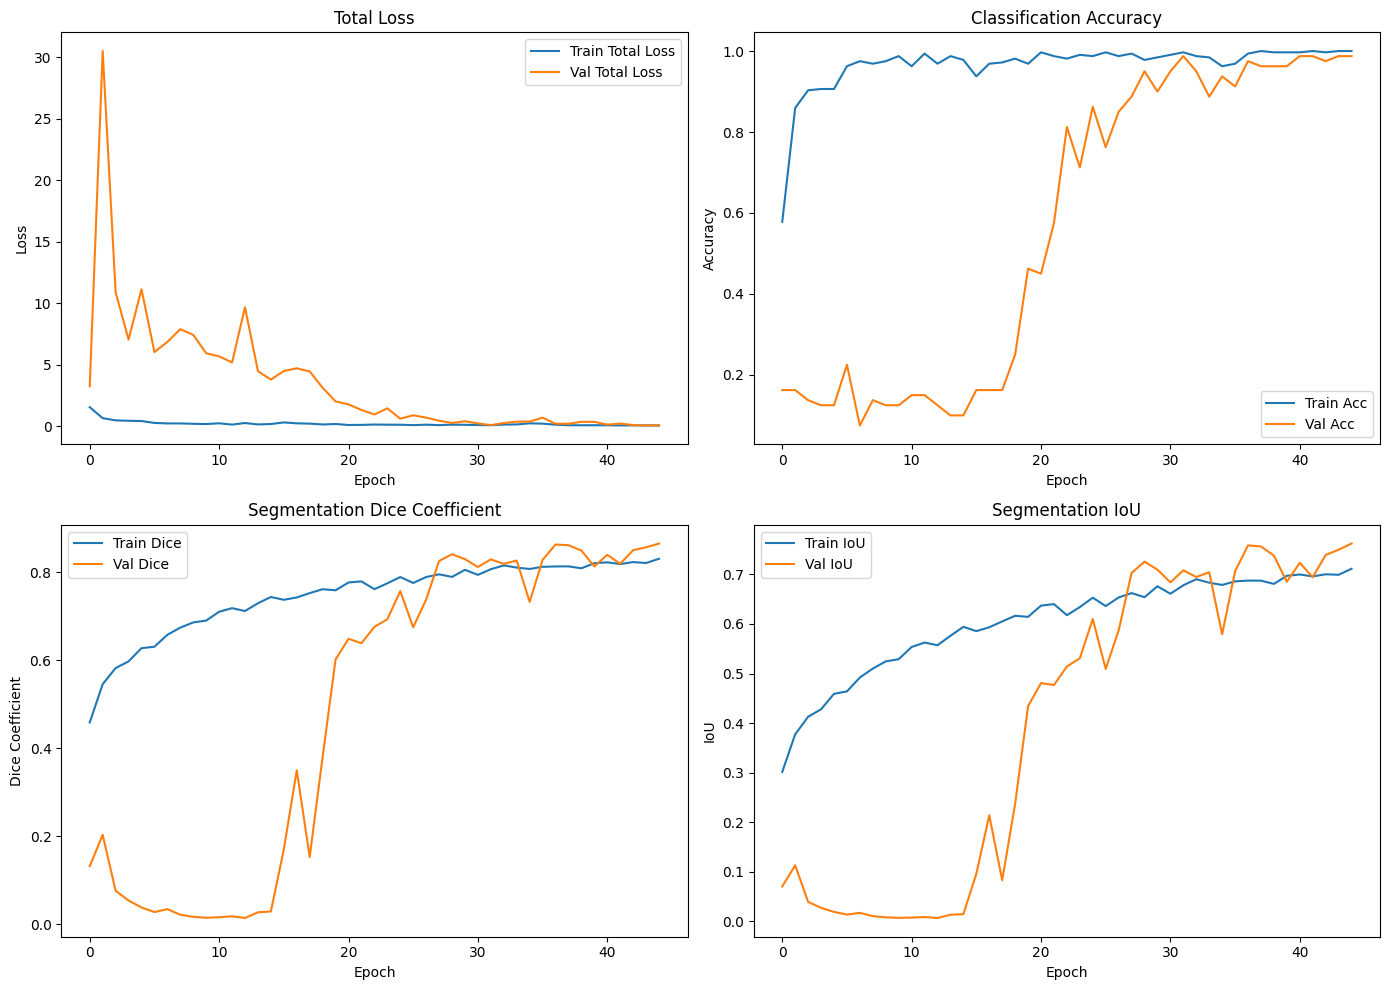

In [ ]:
plot_training_history(history)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- Load your trained model (update the path if needed)
model_path = "/content/drive/My Drive/bloodcell_multitask_model_resnet_unet.h5"
model = load_model(model_path)

# --- Load and preprocess image
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0
    return image

# --- Inference function
def predict_image(image_path):
    img = load_image(image_path)
    input_img = np.expand_dims(img, axis=0)  # shape: (1, 224, 224, 3)

    # Predict
    prediction = model.predict(input_img)

    # If classification + segmentation combined
    if isinstance(prediction, list) and len(prediction) == 2:
        class_pred, mask_pred = prediction
        predicted_class = np.argmax(class_pred[0])
        mask = (mask_pred[0] > 0.5).astype(np.uint8)
    else:
        # Assume only mask prediction
        predicted_class = None
        mask = (prediction[0] > 0.5).astype(np.uint8)

    # Display
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    if predicted_class is not None:
        plt.subplot(1, 3, 2)
        plt.text(0.5, 0.5, f"Predicted Class: {predicted_class}", fontsize=18, ha='center')
        plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

# --- Call this with your test image
#predict_image('/content/drive/My Drive/test_image.jpg')
predict_image = "/content/MO_855807.jpg"


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model
model_path = "/content/drive/My Drive/bloodcell_multitask_model_resnet_unet.h5"
model = load_model(model_path, compile=False)

# Load and preprocess image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = image / 255.0
    return image

# Inference and visualization
def predict_image(image_path):
    img = load_image(image_path)
    input_img = np.expand_dims(img, axis=0)

    print("Input image shape:", input_img.shape)

    prediction = model.predict(input_img)
    print("Model prediction type:", type(prediction))

    if isinstance(prediction, list) and len(prediction) == 2:
        class_pred, mask_pred = prediction
        predicted_class = np.argmax(class_pred[0])
        mask = (mask_pred[0] > 0.5).astype(np.uint8)
    else:
        predicted_class = None
        mask = (prediction[0] > 0.5).astype(np.uint8)

    # Display everything
    plt.figure(figsize=(15, 5))

    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    # Class (if any)
    plt.subplot(1, 3, 2)
    if predicted_class is not None:
        plt.text(0.5, 0.5, f"Predicted Class:\n{predicted_class}", fontsize=18, ha='center', va='center')
        plt.title("Classification Result")
    else:
        plt.text(0.5, 0.5, "No Class Output", fontsize=16, ha='center', va='center')
    plt.axis("off")

    # Mask
    plt.subplot(1, 3, 3)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run it on your test image
predict_image = '/content/MO_855807.jpg'


✅ Image found!
✅ Model loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
🔍 Prediction shape: [(1, 8), (1, 224, 224, 1)]


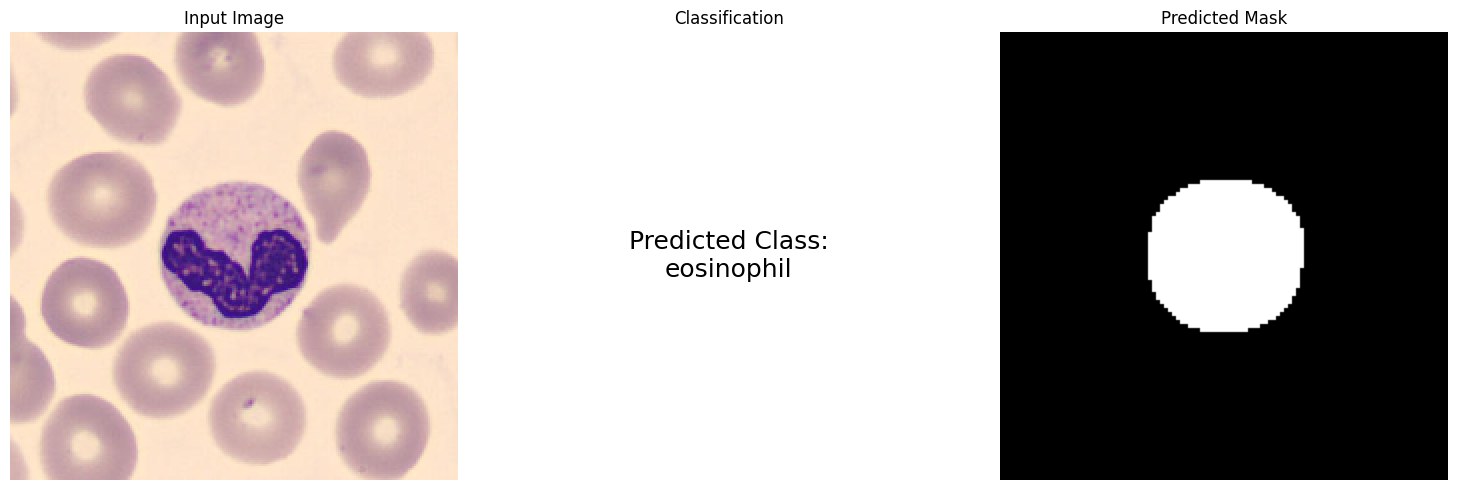

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Set constants
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Class names in the correct training order
CLASS_NAMES = [
    "platelet",      # index 0
    "neutrophil",    # index 1
    "monocyte",      # index 2
    "lymphocyte",    # index 3
    "ig",            # index 4
    "erythroblast",  # index 5
    "eosinophil",    # index 6
    "beshophil"      # index 7
]


# Paths
model_path = "/content/drive/My Drive/bloodcell_multitask_model_resnet_unet.h5"
image_path = "/content/BNE_14932.jpg"

# Step 1: Check image path
if not os.path.exists(image_path):
    print(" Image not found:", image_path)
else:
    print(" Image found!")

# Step 2: Load image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image could not be loaded.")
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

# Step 3: Load model
model = load_model(model_path, compile=False)
print(" Model loaded.")

# Step 4: Predict + Display
def predict_and_display(image_path):
    img = load_image(image_path)
    input_img = np.expand_dims(img, axis=0)

    prediction = model.predict(input_img)
    print("🔍 Prediction shape:",
          [p.shape for p in prediction] if isinstance(prediction, list)
          else prediction.shape)

    if isinstance(prediction, list) and len(prediction) == 2:
        class_pred, mask_pred = prediction
        predicted_class_idx = np.argmax(class_pred[0])
        predicted_class_name = CLASS_NAMES[predicted_class_idx]
        mask = (mask_pred[0] > 0.5).astype(np.uint8)
    else:
        predicted_class_name = None
        mask = (prediction[0] > 0.5).astype(np.uint8)

    # Visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    # Classification
    plt.subplot(1, 3, 2)
    if predicted_class_name is not None:
        plt.text(
            0.5,
            0.5,
            f"Predicted Class:\n{predicted_class_name}",
            fontsize=18,
            ha='center',
            va='center'
        )
    else:
        plt.text(
            0.5,
            0.5,
            "No class output",
            fontsize=14,
            ha='center',
            va='center'
        )
    plt.title("Classification")
    plt.axis("off")

    # Mask
    plt.subplot(1, 3, 3)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

predict_and_display(image_path)
